# Working with Prudence regions

This notebook should demonstrate how to work with subregions of a Cordex domain. Usually, we use subregions in the form of shapefiles or geodataframes which are handley by [regionmask](https://regionmask.readthedocs.io) to mask certain geophysical regions of a cordex domain. Working with 3D boolean mask is mostly based on the excellent [documentation](https://regionmask.readthedocs.io/en/stable/notebooks/mask_3D.html) provided by regionmask.

In [2]:
import intake
from tqdm.autonotebook import tqdm
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import cordex as cx

xr.set_options(keep_attrs=True)

<ipython-input-2-e9a70bd0bba7>:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


We define a proper plotting function for showing rotated pole mappings with coastlines and country borders.

In [3]:
def plot(da, transform=ccrs.PlateCarree(), projection=ccrs.PlateCarree(), vmin=None, vmax=None, borders=True, 
         xlocs=range(-180,180,2), ylocs=range(-90,90,2), extent=None, figsize=(15,10), title=''):
    """plot a domain using the right projections and transformations with cartopy"""
    %matplotlib inline
    import cartopy.crs as ccrs
    import cartopy.feature as cf
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    ax = plt.axes(projection=projection)
    if extent:
        #ax.set_extent([ds_sub.rlon.min(), ds_sub.rlon.max(), ds_sub.rlat.min(), ds_sub.rlat.max()], crs=transform)
        ax.set_extent(extent, crs=projection)
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray',
                      xlocs=xlocs, ylocs=ylocs)
    da.plot(ax=ax, cmap='terrain', transform=transform, vmin=vmin, vmax=vmax)
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    if borders: ax.add_feature(cf.BORDERS)
    if title: ax.set_title('')

The prudence regions are included in form of a coordinates table.

In [6]:
cx.regions.prudence.df

,name,west,east,south,north
area,,,,,
IP,Iberian Peninsula,-10,3,36,44
FR,France,-5,5,44,50
ME,Mid-Europe,2,16,48,55
AL,Alps,5,15,44,48
MD,Mediterranean,3,25,36,44
EA,Eastern Europe,16,30,44,55
NA,Northwestern Africa,-10,12,25,36
MI,Middle East,25,43,25,42
SC,Scandinavia,5,30,55,70


The table is used to create the prudence regionmask object directly from py-cordex.

In [7]:
prudence = cx.regions.prudence.regionmask
prudence

<regionmask.Regions>
Name:     prudence regions

Regions:
0 IP   Iberian Peninsula
1 FR              France
2 ME          Mid-Europe
3 AL                Alps
4 MD       Mediterranean
5 EA      Eastern Europe
6 NA Northwestern Africa
7 MI         Middle East
8 SC         Scandinavia
9 BI       British Isles

[10 regions]

Let's have a look at how the regions look like with the built in plotting function of regionmask.

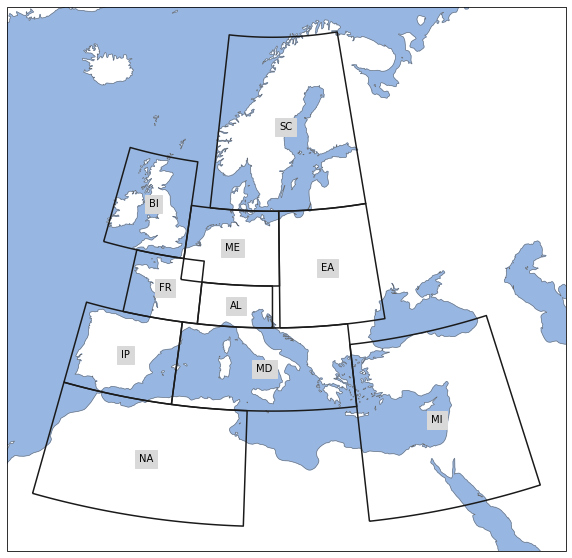

In [9]:
plt.rcParams["figure.figsize"] = (15,10)
proj = ccrs.LambertConformal(central_longitude=15)
ax = prudence.plot(add_ocean=True, proj=proj, resolution="50m", label="abbrev")

As a simple example, we will use the prudence regionmask to mask out a region from a dummy Cordex domain.

In [10]:
eur11 = cx.cordex_domain('EUR-11', dummy='topo')
pole = (eur11.rotated_latitude_longitude.grid_north_pole_longitude, eur11.rotated_latitude_longitude.grid_north_pole_latitude)

The cordex package includes a helper function to create the regions coordinate since overlapping regions are not yet supported, see this [issue](https://github.com/regionmask/regionmask/issues/228).

In [14]:
mask = cx.regions.prudence.mask_3D(eur11.lon, eur11.lat)
mask.region

<xarray.DataArray 'region' (region: 10)>
array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Coordinates:
  * region   (region) int64 0 1 2 3 4 5 6 7 8 9
    abbrevs  (region) <U2 'IP' 'FR' 'ME' 'AL' 'MD' 'EA' 'NA' 'MI' 'SC' 'BI'
    names    (region) <U19 'Iberian Peninsula' 'France' ... 'British Isles'

The mask contains a **region** coordinate that will we can use to mask out EUR-11 dummy topography easily, e.g., to mask the Mediterranean:

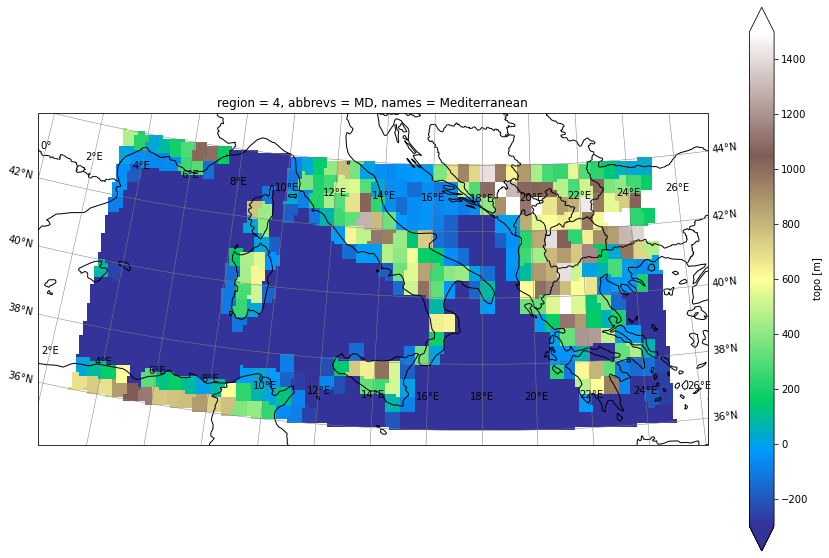

In [15]:
me_topo = eur11.topo.where(mask.isel(region=(mask.abbrevs == "MD")).squeeze(), drop=True)
plot(me_topo, transform=ccrs.RotatedPole(*pole), projection=ccrs.RotatedPole(*pole), vmin=-300, vmax=1500)

## Investigate regional warming in Prudence regions

Now, we will use the regionmask to investiage regional warming of Cordex datasets. This will only work with proper access to Cordex data. This example will work at DKRZ with access to their [intake catalog](https://www.dkrz.de/up/services/data-management/cmip-data-pool). Furthemore, we will use dask to parallelize our computations. For some more detailled explanations, please see also this [notebook on CMIP6 data processing](https://nbviewer.jupyter.org/github/larsbuntemeyer/notebooks/blob/main/CMIP6-global-warming.ipynb).

In [16]:
from dask.distributed import Client, progress
client = Client()
client

Client Scheduler: tcp://127.0.0.1:35573 Dashboard: /user/g300046/advanced//proxy/8787/status,Cluster Workers: 6 Cores: 24 Memory: 29.30 GiB


Let's open the catalog and search for all rcm models with EC-EARTH forcing. We will investigate the warming of the rcp45 scenario with respect to the historical reference periond from 1971 to 2000. The search attributes will return a catalog subset that will give us direct access to the data.

In [17]:
url = "/pool/data/Catalogs/mistral-cordex.json"
cat = intake.open_esm_datastore(url)

In [18]:
attrs = {'driving_model_id': 'ICHEC-EC-EARTH',#'MPI-M-MPI-ESM-LR',
         'member': 'r12i1p1',
       #  'member': 'r1i1p1',
         'variable_id': 'tas',
         'CORDEX_domain': 'EUR-11',
         'frequency': 'mon',
         'rcm_version_id' : 'v1',
         'experiment_id': ['historical', 'rcp45']}

Now we search for our attributes and show the results.

In [19]:
selection = cat.search(**attrs, require_all_on='model_id')
selection.df.groupby(['model_id', 'institute_id', 'experiment_id', 'driving_model_id', 'member', 'frequency', 'rcm_version_id', 'version'])['variable_id'].unique().apply(list).to_frame()

variable_id
model_id          institute_id experiment_id driving_model_id member  frequency rcm_version_id version              
CLMcom-CCLM4-8-17 CLMcom       historical    ICHEC-EC-EARTH   r12i1p1 mon       v1             v20140515       [tas]
                               rcp45         ICHEC-EC-EARTH   r12i1p1 mon       v1             v20140515       [tas]
GERICS-REMO2015   GERICS       historical    ICHEC-EC-EARTH   r12i1p1 mon       v1             v20170410       [tas]
                               rcp45         ICHEC-EC-EARTH   r12i1p1 mon       v1             v20210128       [tas]
KNMI-RACMO22E     KNMI         historical    ICHEC-EC-EARTH   r12i1p1 mon       v1             v20170208       [tas]
                               rcp45         ICHEC-EC-EARTH   r12i1p1 mon       v1             v20170713       [tas]
SMHI-RCA4         SMHI         historical    ICHEC-EC-EARTH   r12i1p1 mon       v1             v20131026       [tas]
                               rcp45         ICHEC-EC-EARTH   r12i1p1 mon       v1             v20131026       [tas]

We have found four RCM datasets that fullfill our critera. We can now load them into a dataset dictionary.

In [20]:
dsets = selection.to_dataset_dict(cdf_kwargs = {"use_cftime": True, "chunks": {'time':1}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'CORDEX_domain.driving_model_id.institute_id.model_id.experiment_id.frequency'


We sort our datasets by the RCM model id and the experiment id's so that we can concatenate the historical and scenario data.

In [21]:
from collections import defaultdict
dsets_dict = defaultdict(dict)

# sort dsets by rcm and exp_id
for key, dset in dsets.items():
    attrs = key.split('.')
    rcm = attrs[3]
    exp = attrs[4]
    dsets_dict[rcm][exp] = dset

Because we want to compare the scenario output to the historical time period, we concatenate the historical and senarion datasets here along the time-axis.

In [22]:
dsets_concat = {rcm : xr.concat([exp['historical'], exp['rcp45']], dim='time', 
                                coords='minimal', compat='override') 
                for rcm, exp in dsets_dict.items()}

Here comes the actual math. This function will compute a yearly mean over the input period and will substract the temporal mean over the reference period. Consequently, this function computes the change in the annual temperature mean in with respect to the reference period.

In [23]:
def compute_change(ds, period, ref_period, mask=None):
    """compute yearly means and compare to reference period"""
    yearmean = ds.sel(time=period).groupby("time.year").mean(dim="time") # yearly means
    ref = ds.sel(time=ref_period).mean(dim="time") # mean over whole period
    results = yearmean - ref
    # lets do some maintenance to keep netcdf meta info...
    results.attrs = ds.attrs
    return results

Let's define out time periods we are interested in and compute the change in the surface temperature for each rcm.

In [24]:
ref_period = slice("1971", "2000")
#common_period = slice("1971","2100")
period = slice("2005", "2100")

In [25]:
yearmeans = {rcm: compute_change(ds, period, ref_period) for rcm, ds in dsets_concat.items()}

Finally, we will concatenate our results into a singel dataset with the model id as a coordinate. This will allow us to easily work with the data of all rcms simultaneoulsy.

**Note**: Here we have to take care for the slightly different rlat and rlon coordinates that might appear in rcms probably due to different cmorizers involded. We can tell xarray to merge all datasets using the coordinates of the first model usint the keywords `compat="override"` and `join="override".`

In [26]:
models = list(dsets_concat.keys())
models

['SMHI-RCA4', 'GERICS-REMO2015', 'KNMI-RACMO22E', 'CLMcom-CCLM4-8-17']

In [27]:
model_da = xr.DataArray(models, dims='model_id', name='model_id',
                      coords={'model_id': models})
changes = xr.concat([ym.tas for ym in yearmeans.values()], dim=model_da, coords="minimal", compat="override", join="override")
changes

<xarray.DataArray 'tas' (model_id: 4, year: 96, member: 1, rlat: 412, rlon: 424)>
dask.array<concatenate, shape=(4, 96, 1, 412, 424), dtype=float32, chunksize=(1, 1, 1, 412, 424), chunktype=numpy.ndarray>
Coordinates:
  * model_id  (model_id) <U17 'SMHI-RCA4' ... 'CLMcom-CCLM4-8-17'
  * rlat      (rlat) float64 -23.38 -23.27 -23.16 -23.05 ... 21.62 21.73 21.84
  * rlon      (rlon) float64 -28.38 -28.27 -28.16 -28.05 ... 17.94 18.05 18.16
    lon       (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
    lat       (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
    height    float64 2.0
  * member    (member) <U7 'r12i1p1'
  * year      (year) int64 2005 2006 2007 2008 2009 ... 2096 2097 2098 2099 2100
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    units:          K
    cell_methods:   time: mean
    grid_mapping:   rotated_pole

Now, we have the temperature change with respect to the historical period for all four RCMs in one dataset. Actually, we have not computed anything since we accessed the data lazily and only worked with meta data so far. This works very well because [xarray uses dask](https://xarray-contrib.github.io/xarray-tutorial/scipy-tutorial/06_xarray_and_dask.html) under the hood. Now, we will trigger the computation using the `persist` function which will keep our data nicely chunked.

In [28]:
changes_ = changes.persist()
progress(changes_)

VBox()

With a proper weighting function, we can now have a quick look at the results of field mean over the whole EUR-11 domain.

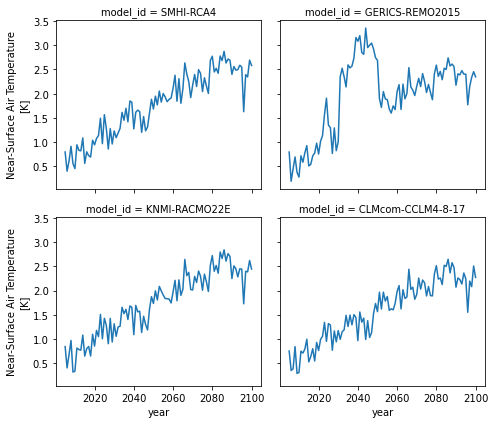

In [29]:
weight = np.cos(np.deg2rad(changes_.rlat))
changes_.weighted(weight).mean(dim=('rlat', 'rlon')).plot(col="model_id", col_wrap=2)

## Add a regions coordinate

In [ ]:
Finally, we will compute a field mean for each prudence region. This can now be easily achieved using xarray weighting in combination with the prudence mask.

In [30]:
prudence_changes = changes_.weighted(mask * weight).mean(dim=("rlat", "rlon"))

and again, we trigger the chunked computation...

In [31]:
prudence_changes_ = prudence_changes.persist()
progress(prudence_changes_)

VBox()

Finally, the plotting becomes as easy as...

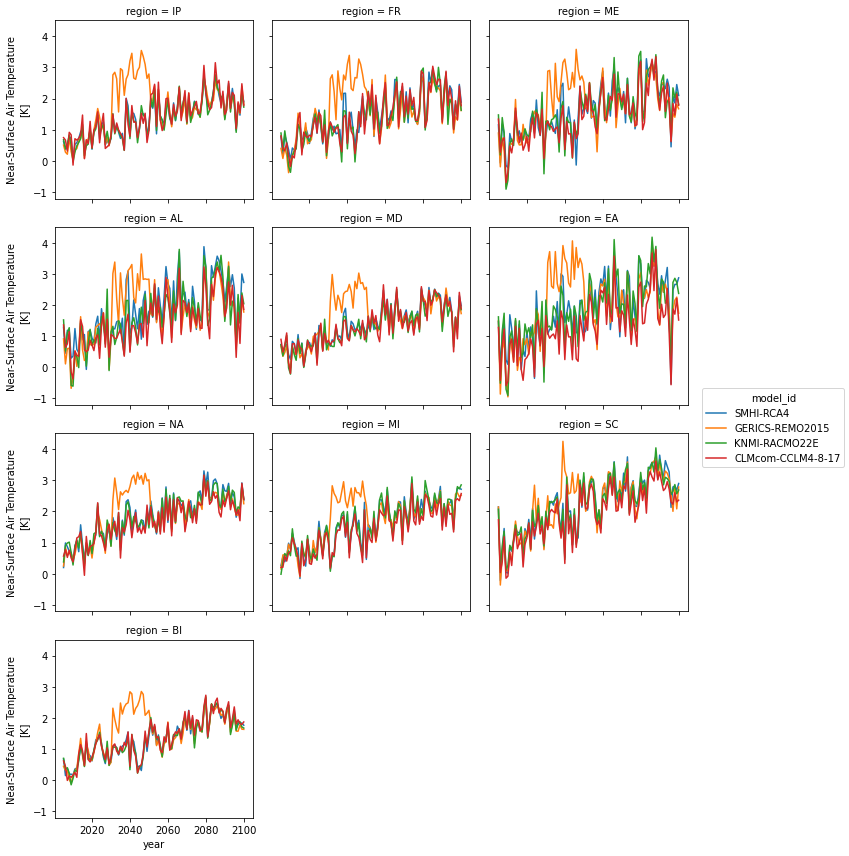

In [32]:
prudence_changes_['region'] = prudence_changes_.abbrevs
prudence_changes_.plot(col='region', col_wrap=3, hue='model_id')